In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("realistic_train_schedule.csv")

# Debugging: Check data types before processing
print(df.dtypes)

Train ID            object
Station Name        object
Date                object
Planned Arrival     object
Actual Arrival      object
Delay (mins)       float64
dtype: object


In [2]:
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt

In [3]:
# --- Clean and preprocess ---

# Drop rows with missing values
df = df.dropna(subset=["Planned Arrival", "Actual Arrival", "Date", "Train ID", "Station Name"])

# Remove 'cancelled' rows from Actual Arrival
df = df[~df["Actual Arrival"].str.contains("cancelled", case=False, na=False)]

# Drop rows where Delay is blank
df = df.dropna(subset=["Delay (mins)"])

# Convert Delay to numeric
df["Delay (mins)"] = pd.to_numeric(df["Delay (mins)"], errors="coerce")
df.dropna(subset=["Delay (mins)"], inplace=True)

# Convert times to datetime
df["Planned Arrival"] = pd.to_datetime(df["Planned Arrival"], format="%H:%M", errors="coerce")
df["Actual Arrival"] = pd.to_datetime(df["Actual Arrival"], format="%H:%M", errors="coerce")
df.dropna(subset=["Planned Arrival", "Actual Arrival"], inplace=True)

# Extract time features
df["Planned_Hour"] = df["Planned Arrival"].dt.hour
df["Planned_Minute"] = df["Planned Arrival"].dt.minute
df["Actual_Hour"] = df["Actual Arrival"].dt.hour
df["Actual_Minute"] = df["Actual Arrival"].dt.minute
df["Peak Hour"] = df["Planned_Hour"].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

# Date features
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Day_of_Week"] = df["Date"].dt.dayofweek
df["Is_Weekend"] = df["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)

#NEW#FEATURES#
# Mean delay per train-station combination (calculate on TRAIN DATA ONLY to avoid leakage)
train_station_avg = df.groupby(['Train ID', 'Station Name'])['Delay (mins)'].mean().reset_index()
train_station_avg.columns = ['Train ID', 'Station Name', 'Train_Station_Avg_Delay']
df = df.merge(train_station_avg, on=['Train ID', 'Station Name'], how='left')

# Peak-hour delays at each station
station_peak_avg = df.groupby(['Station Name', 'Peak Hour'])['Delay (mins)'].mean().reset_index()
station_peak_avg.columns = ['Station Name', 'Peak Hour', 'Station_Peak_Delay']
df = df.merge(station_peak_avg, on=['Station Name', 'Peak Hour'], how='left')

# Overall train punctuality (mean delay per train)
train_avg = df.groupby('Train ID')['Delay (mins)'].mean().reset_index()
train_avg.columns = ['Train ID', 'Train_Avg_Delay']
df = df.merge(train_avg, on='Train ID', how='left')

In [4]:
# Dictionary to hold encoders
label_encoders = {}

# Encode and store the encoders
for col in ["Train ID", "Station Name"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save the encoders dictionary
joblib.dump(label_encoders, "LatencyModel/label_encoder.pkl")

['LatencyModel/label_encoder.pkl']

In [5]:
# Features and target
features = [
    "Train ID", "Station Name", "Planned_Hour", "Planned_Minute",
    "Actual_Hour", "Actual_Minute", "Peak Hour", "Day_of_Week", "Is_Weekend",
     "Train_Station_Avg_Delay",  # New
    "Station_Peak_Delay",       # New
    "Train_Avg_Delay",
]

# === CHANGE TARGET to DELAY IN MINUTES ===
X = df[features]
y = df["Delay (mins)"]

# Split the dataset
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Grid Search Parameters for Regression
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_reg = XGBRegressor(
    objective='reg:squarederror',  # Use squared error for regression
    random_state=42
)

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Fit the best model
best_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=10,
    **grid_search.best_params_
)

best_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score (Negative MSE): ", grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-rmse:13.79376
[1]	validation_0-rmse:13.43402
[2]	validation_0-rmse:13.17381
[3]	validation_0-rmse:13.10895
[4]	validation_0-rmse:12.98228
[5]	validation_0-rmse:12.93114
[6]	validation_0-rmse:12.57486
[7]	validation_0-rmse:12.13253
[8]	validation_0-rmse:11.90604
[9]	validation_0-rmse:11.65481
[10]	validation_0-rmse:11.46976
[11]	validation_0-rmse:11.45161
[12]	validation_0-rmse:11.42156
[13]	validation_0-rmse:11.41584
[14]	validation_0-rmse:11.09531
[15]	validation_0-rmse:10.85231
[16]	validation_0-rmse:10.55709
[17]	validation_0-rmse:10.46313
[18]	validation_0-rmse:10.43118
[19]	validation_0-rmse:10.30470
[20]	validation_0-rmse:10.26628
[21]	validation_0-rmse:9.96757
[22]	validation_0-rmse:9.84507
[23]	validation_0-rmse:9.82310
[24]	validation_0-rmse:9.62907
[25]	validation_0-rmse:9.52790
[26]	validation_0-rmse:9.47858
[27]	validation_0-rmse:9.43815
[28]	validation_0-rmse:9.39713
[29]	validation_0-rmse:9.21


Train Evaluation:
R² Score: 0.9734736488305749
RMSE: 2.359212184078439
MAE: 1.4766641348681373

Validation Evaluation:
R² Score: 0.8617428386623673
RMSE: 5.178612055003851
MAE: 2.3854002196848785

Test Evaluation:
R² Score: 0.8634318312966123
RMSE: 5.165718481764825
MAE: 2.379470846297075


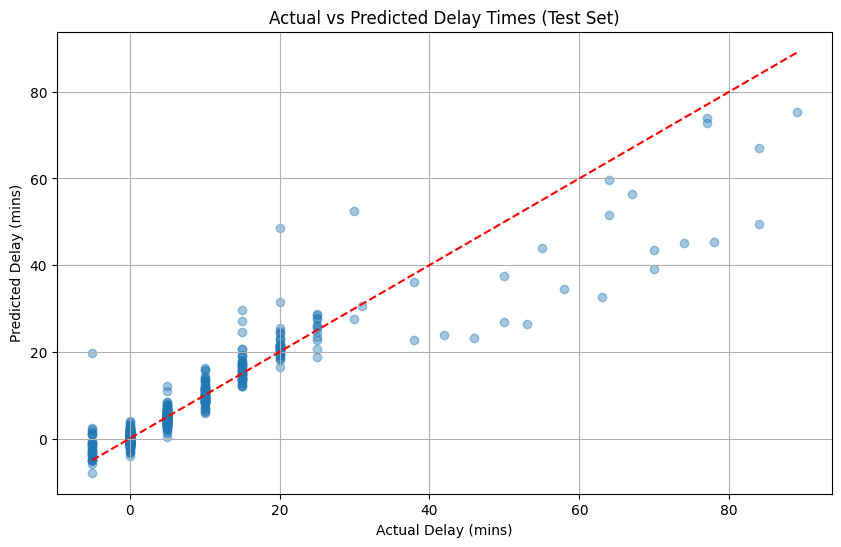

<Figure size 1200x600 with 0 Axes>

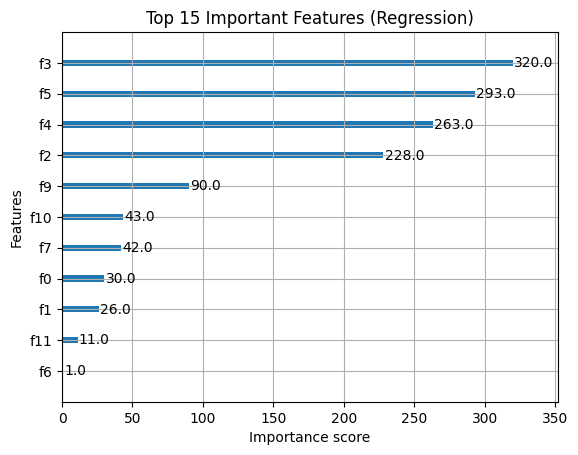

In [6]:
# === Evaluation ===

def evaluate_regression(model, X, y, name="Dataset"):
    preds = model.predict(X)
    print(f"\n{name} Evaluation:")
    print("R² Score:", r2_score(y, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y, preds)))
    print("MAE:", mean_absolute_error(y, preds))
    return preds

train_preds = evaluate_regression(best_model, X_train_scaled, y_train, "Train")
val_preds = evaluate_regression(best_model, X_val_scaled, y_val, "Validation")
test_preds = evaluate_regression(best_model, X_test_scaled, y_test, "Test")

# === Plot Actual vs Predicted for Test Set ===


plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Delay (mins)")
plt.ylabel("Predicted Delay (mins)")
plt.title("Actual vs Predicted Delay Times (Test Set)")
plt.grid(True)
plt.show()

# === Feature Importance ===
plt.figure(figsize=(12,6))
plot_importance(best_model, max_num_features=15)
plt.title("Top 15 Important Features (Regression)")
plt.show()


In [7]:
# Save the model
joblib.dump(best_model, "LatencyModel/xgb_regression_model.pkl")

# Save the model to a binary file
best_model.save_model("LatencyModel/xgb_regression_model.json")

# Save the scaler
joblib.dump(scaler, "LatencyModel/scaler.pkl")

# Save the features list used during training
joblib.dump(features, "LatencyModel/features_list.pkl")

['LatencyModel/features_list.pkl']

In [8]:
import joblib
import xgboost as xgb
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# --- Load all saved components ---
model = joblib.load("LatencyModel/xgb_regression_model.pkl")
scaler = joblib.load("LatencyModel/scaler.pkl")
label_encoders = joblib.load("LatencyModel/label_encoder.pkl")

# Load expected feature names (used in training)
features = joblib.load("LatencyModel/features_list.pkl")

# --- Sample User Input ---
user_input = {
    "Train ID": "Intercity",
    "Station Name": "Colombo Fort",
    "Arrival Time": "08:30",  # 24-hour format
    "Date": "2025-04-10"
}

# --- Convert to DataFrame ---
input_df = pd.DataFrame([user_input])

# --- Handle Categorical Encoding with Error Handling ---
for col in ["Train ID", "Station Name"]:
    le = label_encoders[col]
    if user_input[col] not in le.classes_:
        raise ValueError(f"'{user_input[col]}' not seen during training for {col}. Available classes: {list(le.classes_)}")
    input_df[col] = le.transform([user_input[col]])

# --- Feature Engineering: Convert Date & Time ---
input_df["Date"] = pd.to_datetime(input_df["Date"])
input_df["Weekday"] = input_df["Date"].dt.weekday  # 0 = Monday

# Convert "HH:MM" to hour & minute
arrival_time = datetime.strptime(user_input["Arrival Time"], "%H:%M")
input_df["Arrival_Hour"] = arrival_time.hour
input_df["Arrival_Minute"] = arrival_time.minute

# Example Features (make sure these exist in your model)
input_df["Planned_Hour"] = input_df["Arrival_Hour"]  # Add this based on your business logic
input_df["Planned_Minute"] = input_df["Arrival_Minute"]  # Same for this one
input_df["Actual_Hour"] = input_df["Arrival_Hour"]  # Example, adjust based on your logic
input_df["Actual_Minute"] = input_df["Arrival_Minute"]  # Adjust based on logic
input_df["Train_Station_Avg_Delay"] = 0  # Placeholder for actual logic
input_df["Station_Peak_Delay"] = 0  # Placeholder for actual logic
input_df["Train_Avg_Delay"] = 0  # Placeholder for actual logic

# Drop unused raw columns
input_df = input_df.drop(["Date", "Arrival Time"], axis=1)

# --- Ensure All Features Are Present ---
for feature in features:
    if feature not in input_df.columns:
        input_df[feature] = 0  # Add missing features as 0 or appropriate value

# --- Reorder columns to match training order ---
input_df = input_df[features]

# --- Apply Scaling ---
X_scaled = scaler.transform(input_df)

# --- Predict Delay ---
predicted_delay_mins = model.predict(X_scaled)[0]

# --- Calculate Predicted Arrival Time ---
#predicted_arrival_time = arrival_time + timedelta(minutes=predicted_delay_mins)
# --- Calculate Predicted Arrival Time ---
predicted_arrival_time = arrival_time + timedelta(minutes=float(predicted_delay_mins))

# --- Output ---
print(f"✅ Predicted Delay: {predicted_delay_mins:.2f} minutes")
print(f"⏰ Scheduled Arrival: {arrival_time.strftime('%H:%M')}")
print(f"🚆 Predicted Arrival Time: {predicted_arrival_time.strftime('%H:%M')}")


✅ Predicted Delay: 1.23 minutes
⏰ Scheduled Arrival: 08:30
🚆 Predicted Arrival Time: 08:31
